In [2]:
import pandas as pd
import geopandas as gpd

# Load data
df = pd.read_csv("sample_africa. csv")

# Convert Datetime column
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Timediff'] = ((df['Datetime'] - df['Datetime'].min()).dt.total_seconds())/86400

# Make GeoDataFrame with lon/lat
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Lon'], df['Lat']),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to UTM (auto-detect zone for centroid of data)
gdf = gdf.to_crs(gdf.estimate_utm_crs())

# Extract projected coordinates (in meters)
df['x'] = gdf.geometry.x   # Easting
df['y'] = gdf.geometry.y   # Northing

# Build feature matrix
features = df[['x', 'y', 'Timediff', 'Mag']].values
print(features)

[[ 9.72685767e+05  4.17047302e+06  0.00000000e+00  6.40000000e+00]
 [ 3.02802479e+06  4.75439165e+06  1.96807299e+02  7.30000000e+00]
 [ 2.03778132e+06 -2.85602802e+05  2.40065223e+02  5.30000000e+00]
 ...
 [ 1.11761373e+06  4.27504878e+06  1.62969157e+04  4.80000000e+00]
 [ 2.62701019e+06  4.54628899e+06  1.63005679e+04  5.50000000e+00]
 [-2.83124797e+06 -1.57605129e+05  1.63042073e+04  4.70000000e+00]]


In [3]:
# Data Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
print(features_scaled)

[[0.53540563 0.9173935  0.         0.66666667]
 [0.79526704 0.9762822  0.01207095 0.8974359 ]
 [0.6700682  0.4679944  0.01472413 0.38461538]
 ...
 [0.55372922 0.92794006 0.99955278 0.25641026]
 [0.74456581 0.95529487 0.99977678 0.43589744]
 [0.05446523 0.48090308 1.         0.23076923]]


In [4]:
# Tuning the cluster_selection_epsilon
from sklearn.cluster import HDBSCAN
import numpy as np

eps_values = [0.0, 0.05, 0.1, 0.2, 0.5, 1.0]

for eps in eps_values:
    clusterer = HDBSCAN(min_cluster_size=2,
                        cluster_selection_epsilon=eps,
                        min_samples=2)
    labels = clusterer.fit_predict(features_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = np.mean(labels == -1)
    print(f"epsilon={eps}, clusters={n_clusters}, noise={noise_frac:.2f}")

epsilon=0.0, clusters=656, noise=0.21
epsilon=0.05, clusters=298, noise=0.12
epsilon=0.1, clusters=37, noise=0.03
epsilon=0.2, clusters=3, noise=0.00
epsilon=0.5, clusters=2, noise=0.00
epsilon=1.0, clusters=2, noise=0.00


In [5]:
from sklearn.cluster import HDBSCAN

# Initialize the HDBSCAN model
hdb = HDBSCAN(min_cluster_size=2,
              cluster_selection_epsilon=0.05
              )
hdb.fit(features_scaled)

,min_cluster_size,2
,min_samples,None
,cluster_selection_epsilon,0.05
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [6]:
import matplotlib.pyplot as plt

# Add the resulting cluster labels to the original DataFrame
df['Cluster'] = hdb.labels_

# Count the number of points in each cluster
# This helps understand the distribution of the data
print("--- Cluster ID counts ---")
print(df['Cluster'].value_counts())

--- Cluster ID counts ---
Cluster
 225    479
 296    370
-1      277
 288     66
 270     50
       ... 
 97       2
 219      2
 37       2
 265      2
 111      2
Name: count, Length: 299, dtype: int64


In [7]:
# Classify mainshock, dependent shock and noise in each cluster
# Add a new column for the classification of each event
df['Type'] = 'Dependent'  # Initialize all as Unclassified

# Loop through each cluster (excluding noise: -1)
for cluster_id in sorted(df['Cluster'].unique()):
    if cluster_id == -1: # if cluster id is not equal to -1
        continue  # skip noise

    sub_df = df[df['Cluster'] == cluster_id]  # Make each cluster as a subset from the whole dataframe

    # Identify the mainshock (largest magnitude)
    mainshock_idx = sub_df['Mag'].idxmax()
    mainshock_time = sub_df.at[mainshock_idx, 'Datetime']

    # Assign mainshock
    df.at[mainshock_idx, 'Type'] = 'Mainshock'

# Assign noise (they might be independent shocks)
df.loc[df['Cluster'] == -1, 'Type'] = 'Noise'

print(df)

            Date    Lat    Lon  Depth  Mag  Strike  Dip  Rake        Time  \
0     1976/05/11  37.56  20.35   33.0  6.4     339   14   110  16:59:48.2   
1     1976/11/24  39.12  44.03   36.0  7.3     203   77     9  12:22:18.8   
2     1977/01/06  -2.51  28.70   21.0  5.3     241   45   -90  18:33:43.5   
3     1977/01/07 -31.28 -13.24   33.0  5.5      18   46   -59  14:38:22.4   
4     1977/02/24 -11.69 -13.62   33.0  5.5      74   71    11  08:51:16.6   
...          ...    ...    ...    ...  ...     ...  ...   ...         ...   
2383  2020/12/13 -17.75 -12.75   10.0  4.9     210   40   -32  06:42:00.0   
2384  2020/12/17  35.66  26.26   10.0  4.8     164   45  -116  13:36:45.4   
2385  2020/12/23  38.41  22.07   10.0  4.8     295   44   -59  14:58:24.7   
2386  2020/12/27  38.46  39.23    9.0  5.5     231   36   -22  06:37:32.9   
2387  2020/12/30  -1.25 -13.66   10.0  4.7     341   89     1  21:58:16.1   

                    Datetime      Timediff             x             y  \
0

In [8]:
df['Type'].unique()

array(['Noise', 'Mainshock', 'Dependent'], dtype=object)

In [9]:
# ========================================
# Estimation and further data exploration
# ========================================

In [10]:
# Visualise the clustered sequence on map
import plotly.express as px

df_noise_excluded = df[df['Type'] != 'Noise']

df_noise_excluded['Cluster'] = df_noise_excluded['Cluster'].astype('category')

fig = px.scatter_map(
    df_noise_excluded,
    lat='Lat',
    lon='Lon',
    hover_name='Cluster',
    color='Cluster',
    color_discrete_sequence=px.colors.qualitative.Alphabet,
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    zoom=2,
    height=800,
    map_style='carto-positron',
    title='Earthquake Clustering using HDBSCAN <br><sup>Time of occurrence: 1976-2020 | Africa and its surrounding area</sup>'
)

fig.show()

/var/folders/fn/9d0nx8h147x36gzgyptphd8w0000gn/T/ipykernel_37318/281727860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_excluded['Cluster'] = df_noise_excluded['Cluster'].astype('category')


In [11]:
# Extract the mainshock sequence
declustered_mainshock_hdbscan = df[(df['Type'] == 'Mainshock')].copy()

# Compute inter-arrival timesCompute inter-arrival times to second
declustered_mainshock_hdbscan['inter_arrival'] = declustered_mainshock_hdbscan['Datetime'].diff().dt.total_seconds()
print(declustered_mainshock_hdbscan)

            Date    Lat    Lon  Depth  Mag  Strike  Dip  Rake        Time  \
4     1977/02/24 -11.69 -13.62   33.0  5.5      74   71    11  08:51:16.6   
7     1977/04/06  31.98  50.68   41.0  5.9     220   58    28  13:36:37.1   
9     1977/05/26  38.93  44.38   37.0  5.4     219   86     1  01:35:13.8   
10    1977/06/01  36.24  31.34   67.0  5.7     132   64   155  12:54:49.2   
12    1977/06/05  32.56  48.16   33.0  5.1     289   33    91  08:25:30.8   
...          ...    ...    ...    ...  ...     ...  ...   ...         ...   
2278  2020/03/07  32.41 -16.83    9.0  5.2      72   59  -152  20:58:04.9   
2337  2020/08/04  38.19  38.70   10.0  5.6     235   75   -15  09:37:37.1   
2349  2020/08/20 -34.80 -14.90   10.0  4.6     171   36   -92  17:08:00.8   
2352  2020/08/24 -11.18  34.60   10.0  5.0     139   43  -105  07:03:49.2   
2373  2020/11/22  36.64   6.89   10.0  5.1     103   75   174  03:53:08.5   

                    Datetime      Timediff             x             y  \
4

In [12]:
# The Statistic Features of the Mainshock Sequence
print("The declustered catalogue contains {} events.".format(len(declustered_mainshock_hdbscan)))

max_interval_days = round(declustered_mainshock_hdbscan['inter_arrival'].max() / (24*60*60))
print("The maximum interarrival time between two neighbour independent events is {} days.".format(max_interval_days))

min_interval_min = round(declustered_mainshock_hdbscan['inter_arrival'].min() / 60)
print("The minimum interarrival time between two neighbour independent events is {} minutes.".format(min_interval_min))

The declustered catalogue contains 298 events.
The maximum interarrival time between two neighbour independent events is 424 days.
The minimum interarrival time between two neighbour independent events is 39 minutes.


In [100]:
# Visualise the declustered mainshock sequence on map
import plotly.express as px

fig_mainshock = px.scatter_map(
    declustered_mainshock_hdbscan,
    lat='Lat',
    lon='Lon',
    hover_name='Mag',
    size='Mag',
    size_max=8,
    color='Mag',
    color_continuous_scale='orrd',
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    zoom=2,
    height=800,
    map_style='carto-positron',
    title='Declustered Mainshock Sequence using HDBSCAN<br><sup>Time of occurrence: 1976-2020</sup>'
)

fig_mainshock.show()

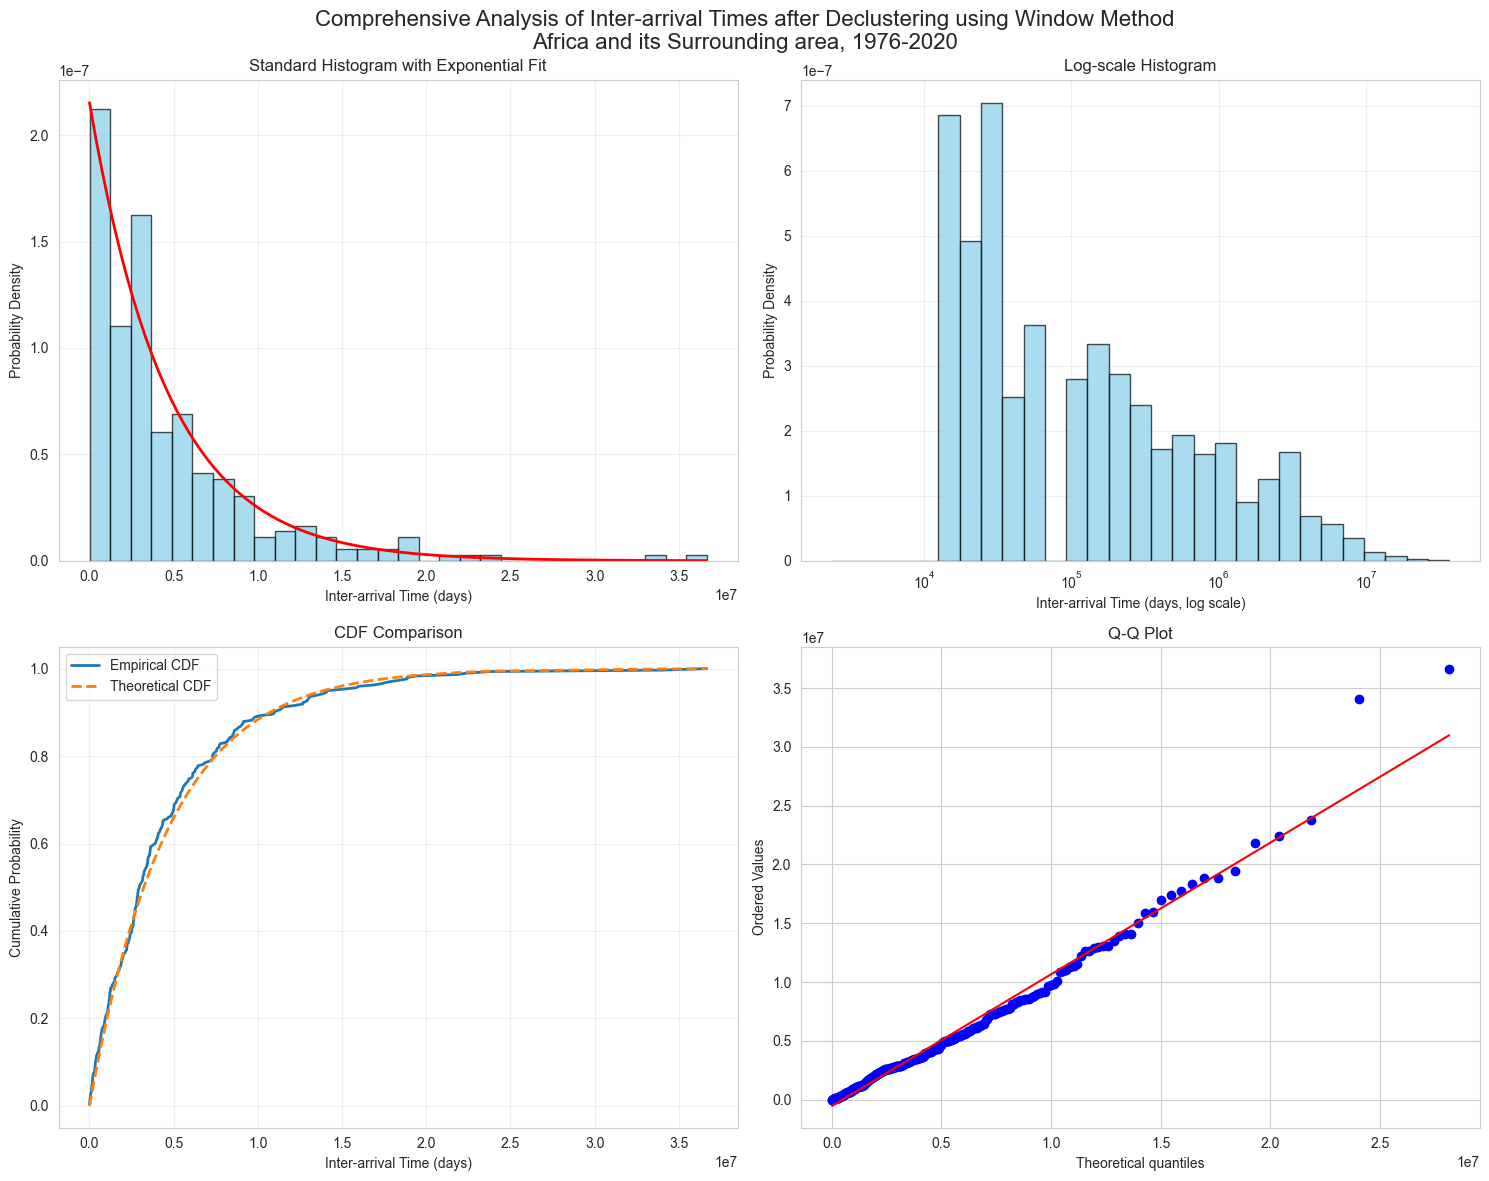

In [18]:
# Visualisation: The inter_arrival times are expected to fit an exponential distribution
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import probplot

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

# Comprehensive analysis for the raw catalogue
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Standard Histogram with Exponential Fit (Top-Left)
axes[0, 0].hist(x, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_range = np.linspace(x.min(), x.max(), 100)
axes[0, 0].plot(x_range, expon.pdf(x_range, loc, scale), 'r-', lw=2)
axes[0, 0].set_title('Standard Histogram with Exponential Fit')
axes[0, 0].set_xlabel('Inter-arrival Time (days)')
axes[0, 0].set_ylabel('Probability Density')
axes[0, 0].grid(True, alpha=0.3)

# Log-scale Histogram (Top-Right)
bins = np.logspace(np.log10(x.min()), np.log10(x.max()), 30)
axes[0, 1].hist(x, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Log-scale Histogram')
axes[0, 1].set_xlabel('Inter-arrival Time (days, log scale)')
axes[0, 1].set_ylabel('Probability Density')
axes[0, 1].grid(True, alpha=0.3)

# CDF Comparison (Bottom-Left)
x_sorted = np.sort(x)
y_ecdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
y_theoretical = expon.cdf(x_sorted, loc, scale)
axes[1, 0].plot(x_sorted, y_ecdf, label='Empirical CDF', linewidth=2)
axes[1, 0].plot(x_sorted, y_theoretical, label='Theoretical CDF', linestyle='--', linewidth=2)
axes[1, 0].set_title('CDF Comparison')
axes[1, 0].set_xlabel('Inter-arrival Time (days)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot (Bottom-Right)
probplot(x, dist=expon, sparams=(loc, scale), plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.savefig('comprehensive_analysis_africa_hdbscan.png', dpi=300, bbox_inches='tight')
plt.suptitle('Comprehensive Analysis of Inter-arrival Times after Declustering using Window Method\nAfrica and its Surrounding area, 1976-2020', fontsize=16)
plt.tight_layout()
plt.show()

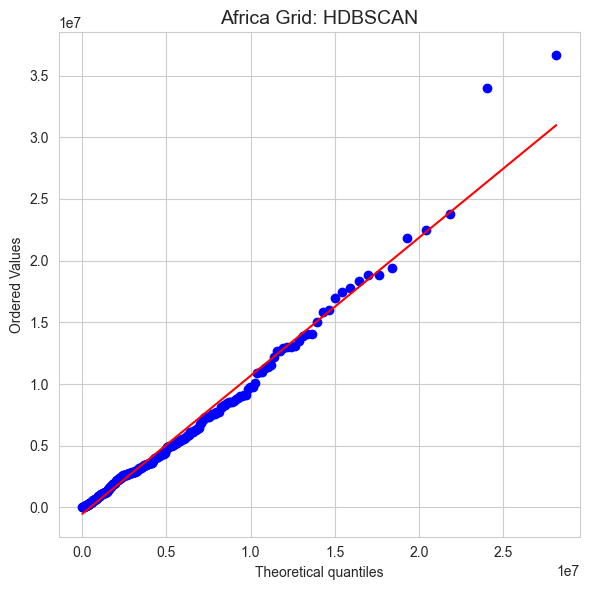

In [17]:
# Q-Q Plot (Zoom out)
x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

plt.figure(figsize=(6, 6))
probplot(x, dist=expon, sparams=(loc, scale), plot=plt)
plt.title("Africa Grid: HDBSCAN", fontsize=14)
plt.tight_layout()
plt.savefig("qq_africa_hdbscan.png", dpi=300)
plt.show()

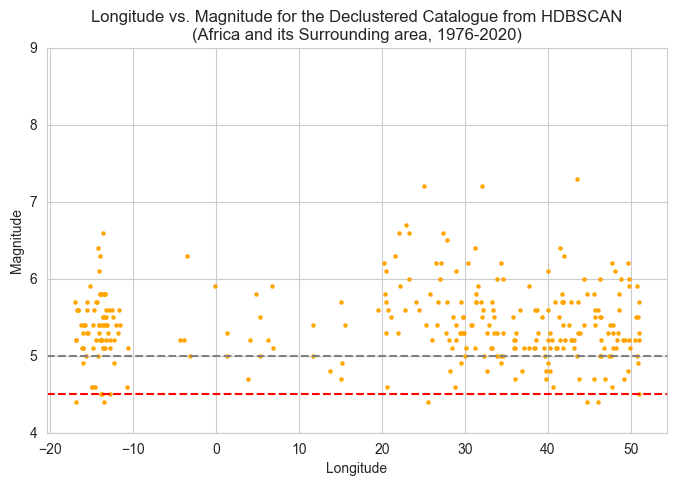

In [13]:
# Lon vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lon']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 9)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Longitude")
plt.ylabel("Magnitude")
plt.title("Longitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(Africa and its Surrounding area, 1976-2020)")
plt.show()

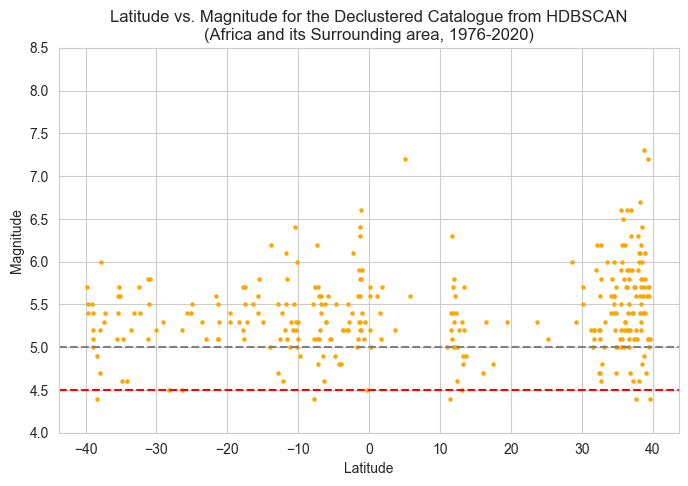

In [19]:
# Lat vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lat']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 8.5)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Latitude")
plt.ylabel("Magnitude")
plt.title("Latitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(Africa and its Surrounding area, 1976-2020)")
plt.show()

In [104]:
# KS test
from scipy.stats import kstest, expon

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

stat, p_value = kstest(x, 'expon', args=(loc, scale))

# If p_value > 0.05, the inter-arrival times are consistent with an exponential distribution.
# This implies that the earthquake occurrences follow a Poisson process.
print(f"K-S test p-value: {p_value:.4f}")
print(f"K-S Test Statistic (D): {stat:.4f}")

METHOD_NAME = "HDBSCAN"
if p_value > 0.05:
    # We fail to reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is consistent with a Poisson process.")
else:
    # We reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is not consistent with a Poisson process.")

K-S test p-value: 0.4121
K-S Test Statistic (D): 0.0509
The declustered catalogue from the HDBSCAN method is consistent with a Poisson process.
